Bank Simulation with 5 Cashiers

In [11]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

class BankSimulation:
    def __init__(self, sim_time, arrival_rate, atm_params, cashier_params, num_cashiers):
        self.sim_time = sim_time
        self.arrival_rate = arrival_rate
        self.atm_params = atm_params
        self.cashier_params = cashier_params
        self.num_cashiers = num_cashiers

        # Environment 
        self.env = simpy.Environment()

        # Resources
        self.atm = simpy.Resource(self.env, capacity=1)
        self.cashiers = simpy.Resource(self.env, capacity=num_cashiers)

        # Metrics
        self.system_times = []
        self.wait_times_cashier = []
        self.wait_times_atm = []
        self.finished_customers = 0
        self.monitor_time = []
        self.queue_lengths_cashier = []
        self.queue_lengths_atm = []
        self.utilization_cashier = []
        self.utilization_atm = []

    def triangular_time(self, params):
        return np.random.triangular(params[0], params[1], params[2])

    def use_atm(self):
        yield self.env.timeout(self.triangular_time(self.atm_params))

    def use_cashier(self):
        yield self.env.timeout(self.triangular_time(self.cashier_params))

    def customer(self, name):
        arrival_time = self.env.now
        # 50% chance they choose the ATM
        if np.random.rand() < 0.5:
            # ATM route
            with self.atm.request() as req:
                queue_start = self.env.now
                yield req
                self.wait_times_atm.append(self.env.now - queue_start)
                yield self.env.process(self.use_atm())
            # 30% chance they have to see the cashier after ATM
            if np.random.rand() < 0.3:
                with self.cashiers.request() as req:
                    queue_start = self.env.now
                    yield req
                    self.wait_times_cashier.append(self.env.now - queue_start)
                    yield self.env.process(self.use_cashier())
        else:
            # other 50% go straight to cashier
            with self.cashiers.request() as req:
                queue_start = self.env.now
                yield req
                self.wait_times_cashier.append(self.env.now - queue_start)
                yield self.env.process(self.use_cashier())

        # recording total time in bank system
        self.system_times.append(self.env.now - arrival_time)
        self.finished_customers += 1

    def generate_arrivals(self):
        while True:
            yield self.env.timeout(np.random.exponential(1 / self.arrival_rate))
            self.env.process(self.customer(f"Customer_{self.finished_customers + 1}"))

    def monitor(self):
        while True:
            self.monitor_time.append(self.env.now)
            self.queue_lengths_cashier.append(len(self.cashiers.queue))
            self.queue_lengths_atm.append(len(self.atm.queue))
            self.utilization_cashier.append(len(self.cashiers.users) / self.cashiers.capacity)
            self.utilization_atm.append(len(self.atm.users))
            yield self.env.timeout(1)

    def simulate(self):
        self.env.process(self.generate_arrivals())
        self.env.process(self.monitor())
        self.env.run(until=self.sim_time)

# Parameters 
SIM_TIME = 1000000  # in minutes
ARRIVAL_RATE = 0.75  # customers per minute (45cust. per hr / 60min)
ATM_PARAMS = (1, 2, 4)
CASHIER_PARAMS = (3, 5, 20)
NUM_CASHIERS = 5

# ---- Run Simulation ---- #
bank = BankSimulation(SIM_TIME, ARRIVAL_RATE, ATM_PARAMS, CASHIER_PARAMS, NUM_CASHIERS)
bank.simulate()

# Output 
print(f"Total customers served: {bank.finished_customers}")
print(f"Average time in system: {np.mean(bank.system_times):.2f} minutes")


Total customers served: 749854
Average time in system: 17.70 minutes


Results

Total customers served: 749854
Cashier utilization: 0.91
Mean queue length at cashier: 4.56
Mean queue length at ATM: 3.30


Text(0, 0.5, 'Frequency')

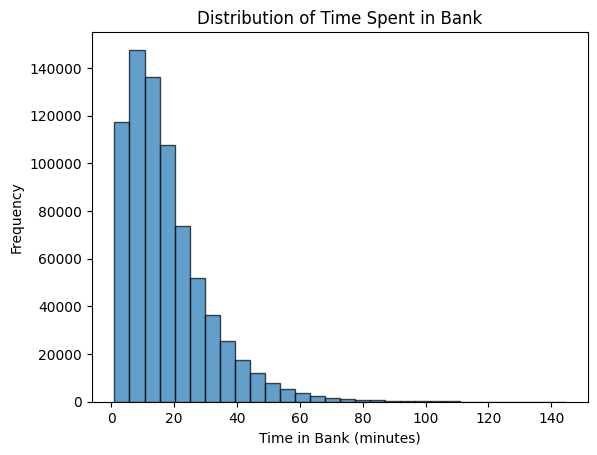

In [12]:

print(f"Total customers served: {bank.finished_customers}")
print(f"Cashier utilization: {np.mean(bank.utilization_cashier):.2f}")
print(f"Mean queue length at cashier: {np.mean(bank.queue_lengths_cashier):.2f}")
print(f"Mean queue length at ATM: {np.mean(bank.queue_lengths_atm):.2f}")
plt.hist(bank.system_times, bins = 30, alpha = 0.7, edgecolor = 'black')
plt.title('Distribution of Time Spent in Bank')
plt.xlabel("Time in Bank (minutes)")
plt.ylabel("Frequency")

Comparison: 6 Cashiers vs. 5 Trained Cashiers

Average time in system: 12.54 minutes
Total customers served: 749945
Cashier utilization: 0.76
Mean queue length at cashier: 0.79
Mean queue length at ATM: 3.18


Text(0, 0.5, 'Frequency')

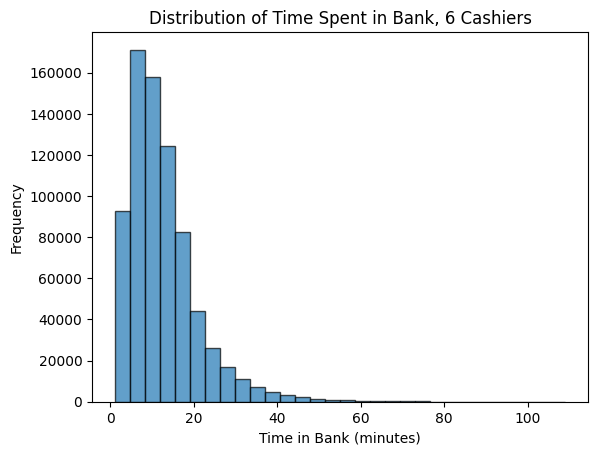

In [13]:
NEW_NUM_CASHIERS = 6

bank = BankSimulation(SIM_TIME, ARRIVAL_RATE, ATM_PARAMS, CASHIER_PARAMS, NEW_NUM_CASHIERS)
bank.simulate()

print(f"Average time in system: {np.mean(bank.system_times):.2f} minutes")
print(f"Total customers served: {bank.finished_customers}")
print(f"Cashier utilization: {np.mean(bank.utilization_cashier):.2f}")
print(f"Mean queue length at cashier: {np.mean(bank.queue_lengths_cashier):.2f}")
print(f"Mean queue length at ATM: {np.mean(bank.queue_lengths_atm):.2f}")
plt.hist(bank.system_times, bins = 30, alpha = 0.7, edgecolor = 'black')
plt.title('Distribution of Time Spent in Bank, 6 Cashiers')
plt.xlabel("Time in Bank (minutes)")
plt.ylabel("Frequency")


Average time in system: 9.76 minutes
Total customers served: 749417
Cashier utilization: 0.58
Mean queue length at cashier: 0.16
Mean queue length at ATM: 3.35


Text(0, 0.5, 'Frequency')

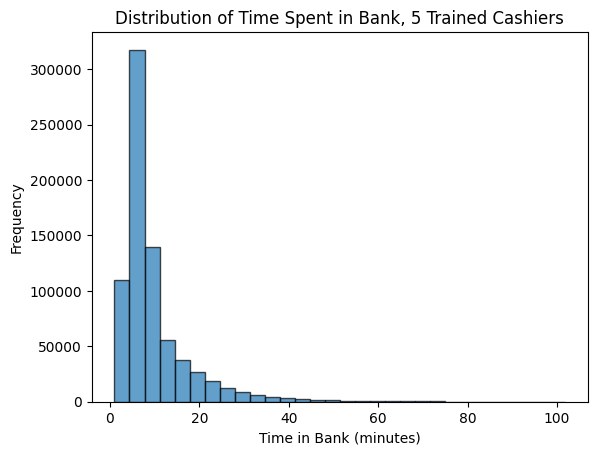

In [14]:
TRAIN_CASHIER_PARAMS = (3, 5, 10)

bank = BankSimulation(SIM_TIME, ARRIVAL_RATE, ATM_PARAMS, TRAIN_CASHIER_PARAMS, NUM_CASHIERS)
bank.simulate()

print(f"Average time in system: {np.mean(bank.system_times):.2f} minutes")
print(f"Total customers served: {bank.finished_customers}")
print(f"Cashier utilization: {np.mean(bank.utilization_cashier):.2f}")
print(f"Mean queue length at cashier: {np.mean(bank.queue_lengths_cashier):.2f}")
print(f"Mean queue length at ATM: {np.mean(bank.queue_lengths_atm):.2f}")
plt.hist(bank.system_times, bins = 30, alpha = 0.7, edgecolor = 'black')
plt.title('Distribution of Time Spent in Bank, 5 Trained Cashiers')
plt.xlabel("Time in Bank (minutes)")
plt.ylabel("Frequency")